<a href="https://colab.research.google.com/github/JonasRiber/Dl_project_HAM10000/blob/main/ham_1000_CVS_jonas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### mounting drive and shared data folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


data = pd.read_csv("/content/drive/My Drive/archive/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/drive/My Drive/archive/HAM10000_metadata.csv")
meta_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data inspection

In [ ]:
## chaking the shape of our data

print(meta_df.shape)
print(data.shape)



(10015, 7)
(10015, 2353)


In [ ]:
### cheking the distrobution of the data in each class
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'),
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


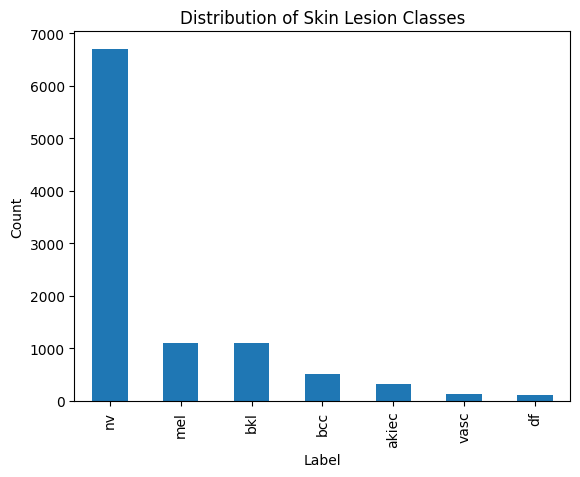

In [ ]:
# Create the histogram
distribution.plot(kind='bar')  # Use kind='bar' for a histogram
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

As seen by the distribution of our classes, there is a massive imbalance in the dataset.
To solve this we can attempt some different procdures. - Undersampling: Match all categories with the lowest frequency category.
- Oversampling: Resample the categories with a low count with replacement like a bootstrap.
- Weighting: Give different classes different weights
- Data augmentation

We attempt to use undersampling first since this is the simplest and most straight forward approach, but it also results in a significant dataloss as we dont suse all the images.

### undersampling


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1. Initialize RandomUnderSampler
sampler = RandomUnderSampler()

# 2. Perform Undersampling
XData, yData = sampler.fit_resample(XData, yData)

# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255.0

XData.shape, yData.shape

((805, 28, 28, 3), (805,))

### Create the train and validation set

In [ ]:

# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape



((644, 28, 28, 3), (161, 28, 28, 3))

### Building CNN
1) imports funtions from keras

2) input shape: input_shape = (28, 28, 3) defines the shape of the input data. This indicates that the model will receive images that are 28 pixels in height and 28 pixels in width with 3 color channels (RGB)

3) Number of Classes: num_classes = 7



In [ ]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3)
num_classes = 7

### Transfered learning - resnet 50

In [ ]:
### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=10)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2395 - loss: 2.8270 - val_accuracy: 0.1553 - val_loss: 9.5613
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3723 - loss: 2.0991 - val_accuracy: 0.1615 - val_loss: 588.5390
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3862 - loss: 1.7793 - val_accuracy: 0.1801 - val_loss: 47.7753
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4089 - loss: 1.5859 - val_accuracy: 0.1801 - val_loss: 60.6734
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4971 - loss: 1.5046 - val_accuracy: 0.1491 - val_loss: 25.0098
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4634 - loss: 1.4521 - val_accuracy: 0.1429 - val_loss: 2.2393
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4308 - loss: 1.5984 - val_accuracy: 0.1491 - val_loss: 40.2441
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4425 - loss: 1.5609 - val_accuracy: 0.180

In [ ]:
from tabulate import tabulate

loss_resnet_under, accuracy_resnet_under = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet_under * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet_under)]]

print(tabulate(table, tablefmt="grid"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1455 - loss: 2.8853 
+---------------+--------+
| Test Accuracy | 16.15% |
+---------------+--------+
| Test Loss     | 2.9326 |
+---------------+--------+


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.16      1.00      0.28        26
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        22

    accuracy                           0.16       161
   macro avg       0.02      0.14      0.04       161
weighted avg       0.03      0.16      0.04       161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


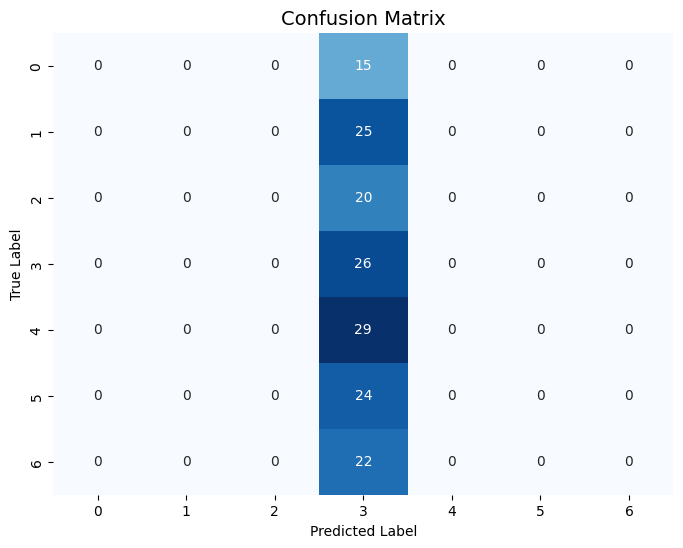

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_resnet50 = Resnet.predict(Xtest_resized)
Ypred_resnet50 = Ypred_resnet50.argmax(axis=1)



print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


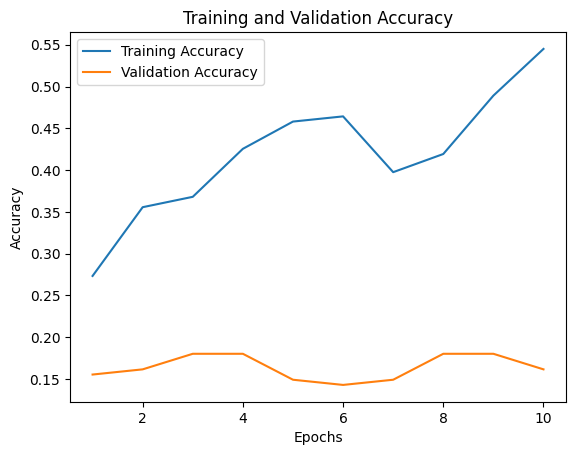

In [ ]:


import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



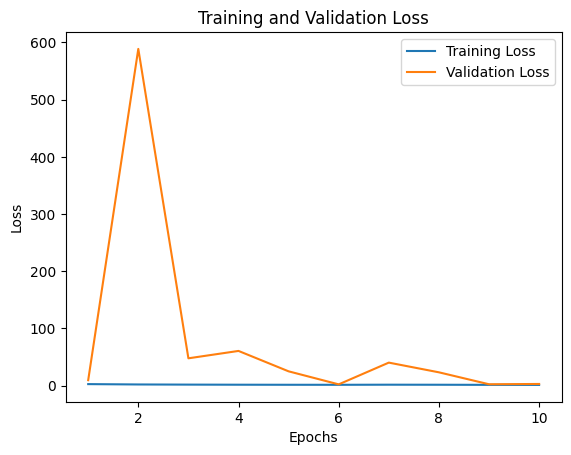

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Improvements by different sampling oversampling instead?

In [ ]:
#redefine data
yData = data['label']
XData = data.drop(columns = ['label'])

# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler #makes batch with we replacement to make it balanced
# 1. Initialize RandomOverSampler
sampler = RandomOverSampler()
# 2. Perform Oversampling
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape


(46935, 28, 28, 3)

In [ ]:
# Creating the train and validation set again from the oversampled data
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

### model is already defined from before

### we still need to refit with the new dataset
history = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=3)

### testing
loss_resnet_over, accuracy_resnet_over = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet_over * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet_over)]]

print(tabulate(table, tablefmt="grid"))

Epoch 1/3
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 71s 61ms/step - accuracy: 0.6477 - loss: 0.9715 - val_accuracy: 0.5790 - val_loss: 1.3265
Epoch 2/3
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8314 - loss: 0.4839 - val_accuracy: 0.7852 - val_loss: 0.5997
Epoch 3/3
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.8730 - loss: 0.3607 - val_accuracy: 0.4890 - val_loss: 1.6731
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4944 - loss: 1.6626
+---------------+--------+
| Test Accuracy | 48.90% |
+---------------+--------+
| Test Loss     | 1.6731 |
+---------------+--------+


294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.35      0.50      1344
           1       0.56      0.42      0.48      1329
           2       0.53      0.36      0.43      1316
           3       0.96      0.25      0.40      1343
           4       0.27      0.86      0.41      1316
           5       0.69      0.91      0.78      1360
           6       0.63      0.26      0.37      1379

    accuracy                           0.49      9387
   macro avg       0.64      0.49      0.48      9387
weighted avg       0.64      0.49      0.48      9387



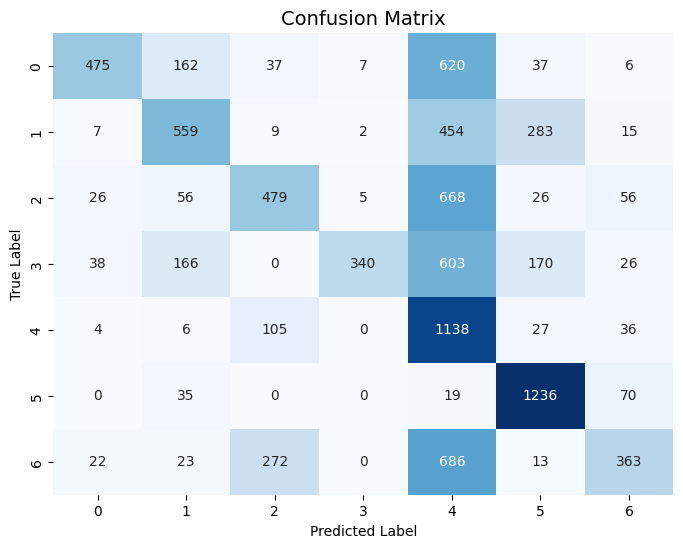

In [ ]:
Ypred_resnet50 = Resnet.predict(Xtest_resized)
Ypred_resnet50 = Ypred_resnet50.argmax(axis=1)

print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

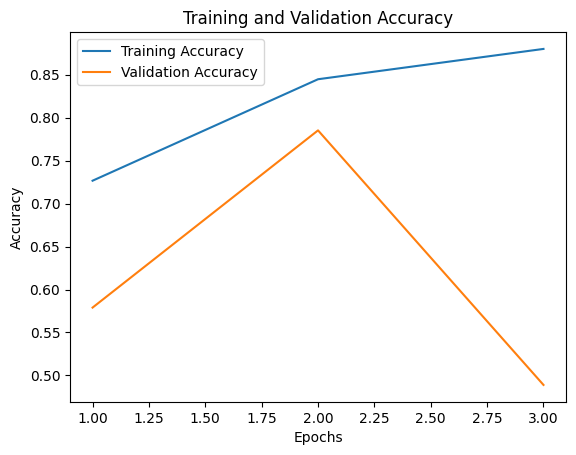

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

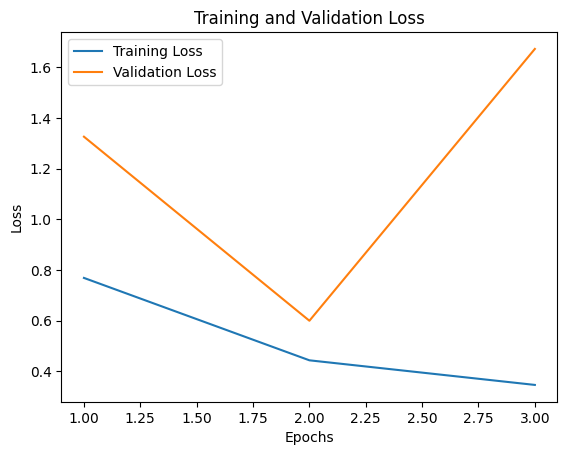

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### weights or data agumentation

### Comparison of the sampling methods


In [ ]:
### test losses and accuracies for the different sampling methods

table = [["\033[1mUndersampling Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet_under * 100)],
         ["\033[1mUndersampling Loss\033[0m", "{:.4f}".format(loss_resnet_under)],
         ["\033[1mOversampling Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet_over * 100)],
         ["\033[1mOversampling Loss\033[0m", "{:.4f}".format(loss_resnet_over)]]

print(tabulate(table, tablefmt="grid"))

+------------------------+--------+
| Undersampling Accuracy | 16.15% |
+------------------------+--------+
| Undersampling Loss     | 2.9326 |
+------------------------+--------+
| Oversampling Accuracy  | 48.90% |
+------------------------+--------+
| Oversampling Loss      | 1.6731 |
+------------------------+--------+


### Multi label classification